# Matrix matrix multiplication performance

In [1]:
import sys
sys.path.append("../") # go to parent dir

import iarray as ia
import numpy as np
from itertools import zip_longest as izip
from time import time
import ctypes
import matplotlib.pyplot as plt
%matplotlib inline


mkl_rt = ctypes.CDLL('libmkl_rt.dylib')
mkl_set_num_threads = mkl_rt.MKL_Set_Num_Threads
nrep = 1

## Data

In [2]:
shape = [4000, 4000]

chunkshape2 = [1000, 1000]
blockshape2 = [250, 250]

dtshape = ia.dtshape(shape, np.float64)

size = int(np.prod(shape))

## Multithreading

In [3]:
max_num_threads = 4
res = []

for num_threads in range(1, max_num_threads + 1):
    print(f"Num. threads: {num_threads}")
    mkl_set_num_threads(num_threads)

    # Numpy and plainbuffer
    storage = ia.StorageProperties(plainbuffer=True)
    kwargs = dict(nthreads=num_threads)

    a = ia.linspace(dtshape, -1, 1, size, storage=storage, **kwargs)
    an = ia.iarray2numpy(a)

    b = ia.linspace(dtshape, -1, 1, size, storage=storage, **kwargs)
    bn = ia.iarray2numpy(b)

    print("- Numpy...")

    mkl_set_num_threads(num_threads)
    t0 = time()
    for _ in range(nrep):
        cn2 = np.matmul(an, bn)
    t1 = time()
    t_np = (t1 - t0) / nrep

    mkl_set_num_threads(1)
    print("- Plainbuffer...")
    t0 = time()
    for i in range(nrep):
        c = ia.matmul(a, b, storage=storage, nthreads=num_threads)
    t1 = time()
    t_ia = (t1 - t0) / nrep

    # Superchunk without compression
    storage = ia.StorageProperties(chunkshape2, blockshape2)
    kwargs = dict(nthreads=num_threads, clevel=0)

    a = ia.linspace(dtshape, -1, 1, size, storage=storage, nthreads=num_threads, clevel=0)
    b = ia.linspace(dtshape, -1, 1, size, storage=storage, nthreads=num_threads, clevel=0)

    print("- Superchunk without compression...")
    t0 = time()
    for i in range(nrep):
        c = ia.matmul(a, b, storage=storage, nthreads=num_threads, clevel=0)
    t1 = time()
    t_ia_s = (t1 - t0) / nrep
    
    # Superchunk with compression
    storage = ia.StorageProperties(chunkshape2, blockshape2)
    kwargs = dict(nthreads=num_threads, clevel=5)

    a = ia.linspace(dtshape, -1, 1, size, storage=storage, nthreads=num_threads, clevel=5)
    b = ia.linspace(dtshape, -1, 1, size, storage=storage, nthreads=num_threads, clevel=5)

    print("- Superchunk with compression...")
    t0 = time()
    for i in range(nrep):
        c = ia.matmul(a, b, storage=storage, nthreads=num_threads, clevel=5)
    t1 = time()
    t_ia_sc = (t1 - t0) / nrep

    # Append data
    
    res.append([t_np, t_ia, t_ia_s, t_ia_sc])

Num. threads: 1
- Numpy...
- Plainbuffer...
- Superchunk without compression...
- Superchunk with compression...
Num. threads: 2
- Numpy...
- Plainbuffer...
- Superchunk without compression...
- Superchunk with compression...
Num. threads: 3
- Numpy...
- Plainbuffer...
- Superchunk without compression...
- Superchunk with compression...
Num. threads: 4
- Numpy...
- Plainbuffer...
- Superchunk without compression...
- Superchunk with compression...


## Results

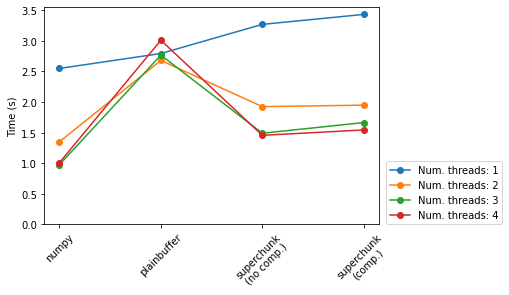

In [4]:
xticks = ("numpy", "plainbuffer", "superchunk\n(no comp.)", "superchunk\n(comp.)")
plt.xticks(range(len(xticks)), xticks)
for i in range(0, max_num_threads):
    plt.plot(res[i], "o-", label=f"Num. threads: {i+1}")
plt.xticks(rotation=45)
plt.ylabel("Time (s)")
plt.ylim(0)
plt.legend(loc=(1.02, 0))
plt.show()